### Not in manuscript 

Make sure to install LASIO package to read LAS files.

#### pip install lasio

Also make sure you have sklearn package installed as we will be using that module exclusively for this tutorial.



## Predicting Logs using Machine Learning
### Sundeep Sharma, Devon Energy, email: Sundeep.Sharma@dvn.com

Well logs are an integral part of a 

In [4]:
# NOT IN MANUSCRIPT
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lasio

In [35]:
# NOT IN MANUSCRIPT
training_path='./training_logs/'
blind_path='./blind_logs/'

This tutorial will go through a simple way to predict sonic logs using multiple linear regression. The tutorial will utilize logs from the Teapot Dome 3D dataset available for public use (https://wiki.seg.org/wiki/Open_data). To begin with, let's import the logs within the training folder and combine them into a training set. We will use the $\it{lasio}$ library to read in the two LAS files in the training folder and combine them using $\it{pandas}$ library. We will make sure to remove any $\it{nan's}$ and extract only the required curves, which are Depth, DT, GRR, NPHI, ILD, RHOB and UWI. Let's look at the first five data points of our training dataset for quality control purposes. 

In [36]:
# NOT IN MANUSCRIPT
df_combined=pd.DataFrame()
for (dirname,dirs,files) in os.walk(training_path):
    for fl in files:
        if fl.endswith('.LAS'):
            log=lasio.read(os.path.join(training_path,fl))
            log.curves['DEPT'].mnemonic='DEPTH'
            uwi=log.well.API.value
            name=log.well.WELL.value
            df_core=log.df()
            df_core['UWI']=uwi
            df_combined=pd.concat([df_combined, df_core])

            
training=df_combined[['DEPTH','DT','GRR','NPHI','ILD','RHOB','UWI']]

training=training.dropna(how='any')
training=training.reset_index(drop=True)


In [37]:
training.head()

,DEPTH,DT,GRR,NPHI,ILD,RHOB,UWI
0,2088.0,91.578,94.849,0.233,6.296,2.472,49025109650000
1,2088.5,91.578,91.132,0.233,6.244,2.473,49025109650000
2,2089.0,91.578,87.114,0.238,6.165,2.484,49025109650000
3,2089.5,91.578,85.320,0.237,6.086,2.493,49025109650000
4,2090.0,91.578,84.879,0.235,6.007,2.493,49025109650000


## Training/Test Phase

Now that we have the training dataset, we will go through the training/test phase. Firstly, we will shuffle the data to ensure we get rid of any bias/patterns within the dataset before we split the data into training and validation sets. 

In [38]:
training=shuffle(training,random_state=20)
drop_curves=['DEPTH','DT','UWI']

feature_vectors=training.drop(drop_curves,axis=1)

y_actual=training['DT'].values

We will split the data into $20\%$ test set and $80\%$ training set. Next, we will standerdize the dataset, which is a way of making the features Gaussian with zero mean and unit variance. We will use the same scalar to standerdize the blind dataset that we will test on. 

In [39]:
from sklearn import model_selection
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)


validation_size = 0.20 
seed = 42
scoring = 'accuracy'
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(scaled_features,                                                                                
                                 y_actual,                                               
                                 test_size=validation_size,                                                                                 
                                 random_state=seed)


In [40]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# RIDGE REGRESSION #
reg = linear_model.Ridge(alpha=1,tol=0.01, solver='sag')
ridge_reg = reg.fit(X_train, Y_train).predict(X_validation)

# LINEAR REGRESSION #
lin_reg = linear_model.LinearRegression()
reg_lin = lin_reg.fit(X_train, Y_train).predict(X_validation)

# LASSO #
lasso=linear_model.LassoCV(eps=0.001, n_alphas=100)
lasso_lin=lasso.fit(X_train,Y_train).predict(X_validation)

In [41]:
# POLYNOMIAL FITTING FOR ALL THE ALGORITHMS USED #
fit_fn1 = np.poly1d(np.polyfit(Y_validation,ridge_reg, 1)) 
fit_fn2 = np.poly1d(np.polyfit(Y_validation,reg_lin, 1)) 
fit_fn3 = np.poly1d(np.polyfit(Y_validation,lasso_lin, 1)) 

# CALCULATE R2 FOR ALL THE PREDICTIONS #
lr_r2=r2_score(Y_validation,reg_lin)
ridge_r2=r2_score(Y_validation,ridge_reg)
lasso_r2=r2_score(Y_validation,lasso_lin)

print "R2 for Linear Regression:", lr_r2
print "R2 for Ridge Regression:", ridge_r2
print "R2 for Lasso:", lasso_r2

R2 for Linear Regression: 0.725676548108
R2 for Ridge Regression: 0.72570613349
R2 for Lasso: 0.725664436619


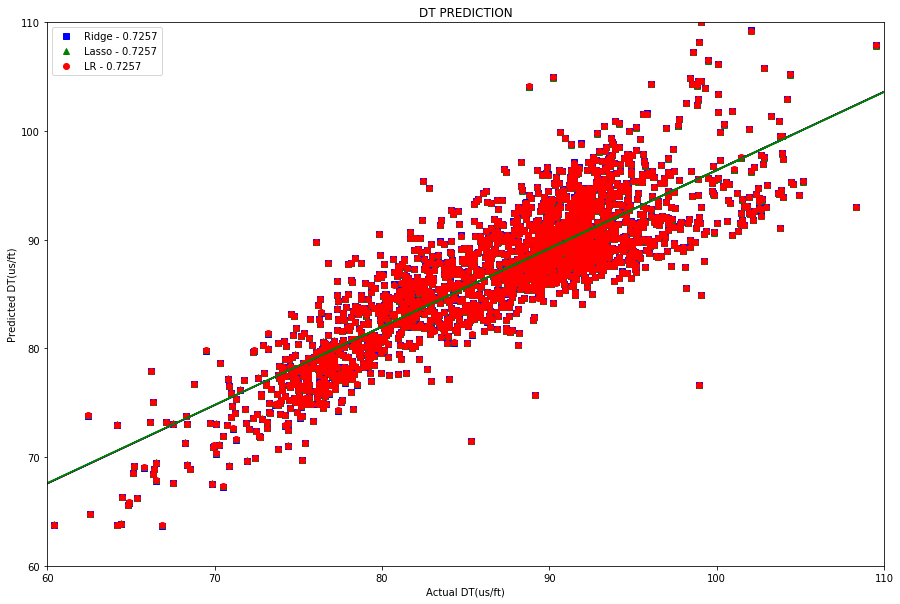

In [42]:
fig = plt.figure(figsize=(15, 10))
plt.plot(Y_validation,ridge_reg,'bs',Y_validation,lasso_lin,'g^',
         Y_validation,reg_lin,'ro',
         Y_validation,fit_fn1(Y_validation),
         'r-',Y_validation,fit_fn2(Y_validation),'b-',
         Y_validation,fit_fn3(Y_validation),'g-')
plt.xlabel('Actual DT(us/ft)')
plt.ylabel('Predicted DT(us/ft)')
plt.legend(['Ridge - '+str(round(ridge_r2,4)),'Lasso - '+str(round(lasso_r2,4)),
            'LR - '+str(round(lr_r2,4))])
plt.xlim(60,110)
plt.ylim(60,110)
plt.title('DT PREDICTION')
plt.show()

We can also check the Mean Squared Error (MSE) of the validation and predicted dataset. $\it{Sklearn}$ metrics has a handy MSE function.

In [43]:
print "MSE for Ridge Regression is",mean_squared_error(Y_validation,ridge_reg)
print "MSE for Ridge Regression is",mean_squared_error(Y_validation,reg_lin)
print "MSE for Ridge Regression is",mean_squared_error(Y_validation,lasso_lin)


MSE for Ridge Regression is 16.224846729
MSE for Ridge Regression is 16.2265967436
MSE for Ridge Regression is 16.2273131543


In [127]:
# Residual plots

# plt.scatter(ridge_reg,ridge_reg- Y_train)
# plt.how()
ridge_reg.shape

(2206L,)

## Blind Well Prediction

In [119]:
bl='49025109060000_283718.LAS'
blind_log=lasio.read(os.path.join(blind_path,bl))
blind_log.curves['DEPT'].mnemonic='DEPTH'
blind=blind_log.df()
blind['UWI']=blind_log.well.API.value
blind_data=blind[['DEPTH','DT','GRR','NPHI','ILD','RHOB','UWI']]

blind_data=blind_data.dropna(how='any')
blind_data=blind_data.reset_index(drop=True)

In [120]:
blind_features=blind_data.drop(drop_curves,axis=1)
X_blind = scaler.transform(blind_features)

In [121]:
Y_pred_ridge=lin_reg.predict(X_blind) # RIDGE Prediction
Y_pred_lasso=lasso.predict(X_blind) # Lasso Prediction
Y_pred_reg=lin_reg.predict(X_blind) # LR Prediction
y_blind = blind_data['DT'].values

In [122]:
fit1 = np.poly1d(np.polyfit(y_blind,Y_pred_ridge, 1)) 
fit2 = np.poly1d(np.polyfit(y_blind,Y_pred_lasso, 1)) 
fit3 = np.poly1d(np.polyfit(y_blind,Y_pred_reg, 1)) 

In [123]:
pred_ridge_r2=r2_score(y_blind,Y_pred_ridge)
pred_lasso_r2=r2_score(y_blind,Y_pred_lasso)
pred_lr_r2=r2_score(y_blind,Y_pred_reg)

print "R2 for Linear Regression:", pred_lr_r2
print "R2 for Ridge Regression:", pred_ridge_r2
print "R2 for Lasso:", pred_lasso_r2


R2 for Linear Regression: 0.806469830103
R2 for Ridge Regression: 0.806469830103
R2 for Lasso: 0.806273723339


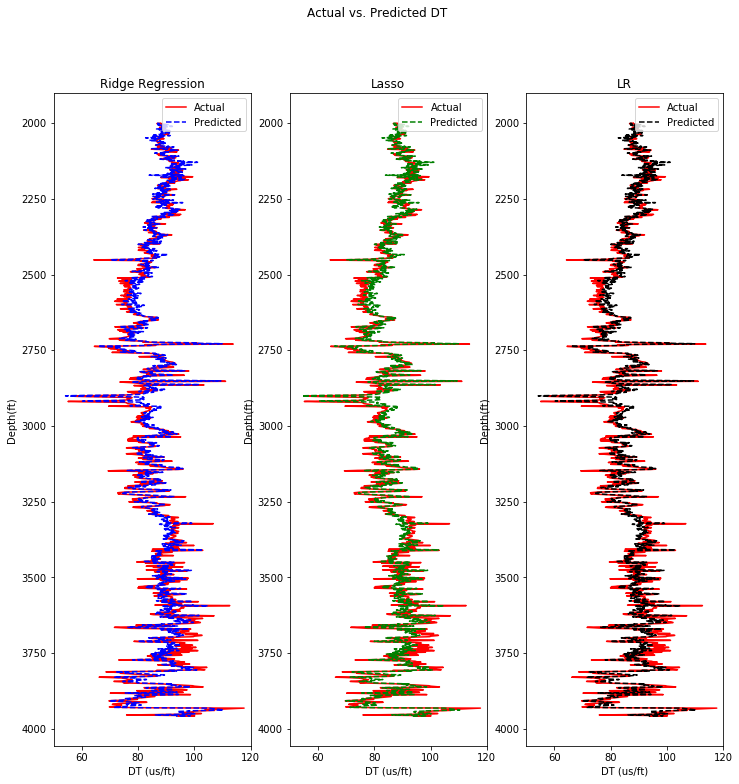

In [124]:
f,ax = plt.subplots(nrows=1,ncols=3, figsize=(12, 12))
ax[0].plot(y_blind,blind_data.DEPTH,color='r',label='Actual')
ax[0].plot(Y_pred_ridge,blind_data.DEPTH,color='b',linestyle='--',label='Predicted')
ax[0].invert_yaxis()
ax[0].set_xlabel('DT (us/ft)')
ax[0].set_ylabel('Depth(ft)')
ax[0].legend(loc="upper right")
ax[0].set_title('Ridge Regression')
ax[0].set_xlim([50,120])

ax[1].plot(y_blind,blind_data.DEPTH,color='r',label='Actual')
ax[1].plot(Y_pred_lasso,blind_data.DEPTH,color='g',linestyle='--',label='Predicted')
ax[1].invert_yaxis()
ax[1].set_xlabel('DT (us/ft)')
ax[1].set_ylabel('Depth(ft)')
ax[1].legend(loc="upper right")
ax[1].set_title('Lasso')
ax[1].set_xlim([50,120])

ax[2].plot(y_blind,blind_data.DEPTH,color='r',label='Actual')
ax[2].plot(Y_pred_reg,blind_data.DEPTH,color='k',linestyle='--',label='Predicted')
ax[2].invert_yaxis()
ax[2].set_xlabel('DT (us/ft)')
ax[2].set_ylabel('Depth(ft)')
ax[2].legend(loc="upper right")
ax[2].set_title('LR')
ax[2].set_xlim([50,120])

plt.suptitle('Actual vs. Predicted DT')
plt.show()